In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Define new CLM profile that has no adiabatic contraction

In [7]:
class NewCLM(bfg.DarkMatter, bfg.Schneider19.SchneiderFractions):
    
    def _real(self, cosmo, r, M, a):
        
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        z = 1/a - 1

        R = self.mass_def.get_radius(cosmo, M_use, a)/a #in comoving Mpc
        
        f_sga  = self._get_star_frac(M_use, a, cosmo)[2]
        f_clm  = 1 - cosmo.cosmo.params.Omega_b/cosmo.cosmo.params.Omega_m + f_sga
        
        prof = f_clm * super()._real(cosmo, r, M, a)
        
        #Handle dimensions so input dimensions are mirrored in the output
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        
        return prof

# Now setup models

In [8]:
DMO = bfg.DarkMatterOnly(**bpar)
DMB = bfg.DarkMatterBaryon(**bpar)

Baryons3D = bfg.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Baryons3D.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2, 
                             R_min = 1e-5, R_max = 5e3, N_samples_R = 1_000, z_linear_sampling = True, verbose = False);

CLM = NewCLM(**bpar)
DMB = bfg.DarkMatterBaryon(collisionlessmatter = CLM, **bpar)

TMP = bfg.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
TMP.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2, 
                       R_min = 1e-5, R_max = 5e3, N_samples_R = 1_000, z_linear_sampling = True, verbose = False);

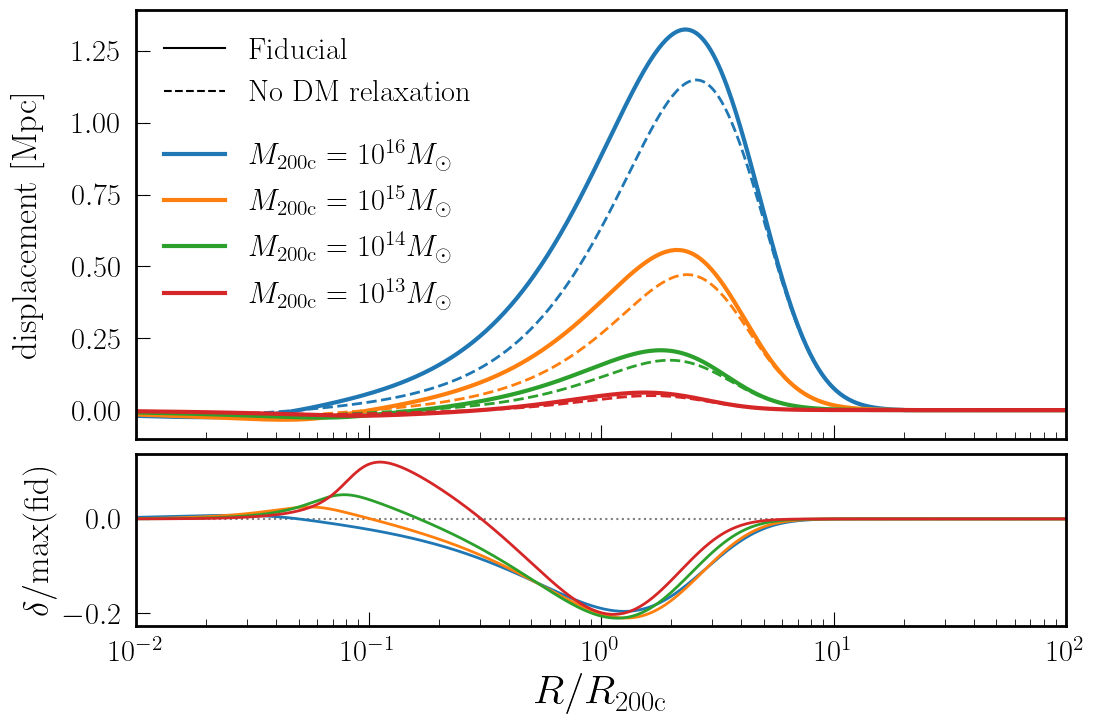

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (12,8), gridspec_kw = {'height_ratios' : [5, 2]}, sharex = True)
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
ax[0].set_xscale('log')

for M in [1e13, 1e14, 1e15, 1e16][::-1]:
    a = 1    
    R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
    R = np.geomspace(1e-4, 1000, 10_000)
    
    c = ax[0].plot(R/R200c, Baryons3D.displacement(R*a, M, a), lw = 3, label = r'$M_{\rm 200c} = 10^{%d} M_\odot$' % int(np.log10(M)))
    ax[0].plot(R/R200c, TMP.displacement(R*a, M, a), lw = 2, color = c[0].get_color(), ls = '--')

    ax[1].plot(R/R200c, (TMP.displacement(R*a, M, a) - Baryons3D.displacement(R*a, M, a))/np.max(Baryons3D.displacement(R*a, M, a)), lw = 2, color = c[0].get_color(),)

a = ax[0].legend(fontsize = 22, frameon = False, loc = 'center left')
plt.xlim(1e-2, 1e2)
[a.tick_params(axis = 'both', pad = 10, ) for a in ax]
b = ax[0].legend([plt.plot([], [], lw = 1.5, color = 'k', ls = '-')[0],
                   plt.plot([], [], lw = 1.5, color = 'k', ls = '--')[0]],
                  ['Fiducial', 'No DM relaxation'], fontsize = 22, frameon = False, loc = 'upper left')
ax[0].add_artist(a)
ax[1].set_xlabel(r'$R/R_{\rm 200c}$', size = 30)
ax[0].set_ylabel(r'displacement [Mpc]', size = 25, labelpad = 20)
ax[1].set_ylabel(r'$\delta / \rm max(fid)$', size = 25, )

ax[1].axhline(0, color = 'k', ls = ':', alpha = 0.5, zorder = -100)